<a href="https://colab.research.google.com/github/2021-FIIT-Bc-projects/BP-Eliseeva-Najdiskutovanejsie_temy_v_dokumentoch/blob/main/Bakalarka_NIPS_nltk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
# pip install pyLDAvis

In [87]:
# pip install -U tmtoolkit

In [88]:
import gensim
import nltk
import pandas as pd
import re
import collections
import itertools
import warnings
import pyLDAvis
import pyLDAvis.gensim_models

from gensim import corpora
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from pprint import pprint

import matplotlib.pyplot as plt
import spacy
from tmtoolkit.topicmod.tm_gensim import evaluate_topic_models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [89]:
import pkg_resources
print(pkg_resources.get_distribution('gensim').version)
print(pkg_resources.get_distribution('nltk').version)
print(pkg_resources.get_distribution('pandas').version)
print(pkg_resources.get_distribution('spacy').version)
# print(pkg_resources.get_distribution('pyLDAvis').version)
print(pkg_resources.get_distribution('wordcloud').version)
print(pkg_resources.get_distribution('matplotlib').version)


3.6.0
3.2.5
1.1.5
2.3.7
1.5.0
3.3.4


In [90]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['let', 'fig'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.7). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [91]:
def measure_model(model):
  #perplexity
  print(model.log_perplexity(corpus_test))
  #coherence
  coherence_model_lda = CoherenceModel(model=model, texts=data_all_lemmatized, dictionary=id2word, coherence='c_v')
  print(coherence_model_lda.get_coherence())

In [92]:
def ShowWordCloud(data):
    string = ','.join(str(text) for text in data)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, regexp=r"\w[\w']+\w").generate(string)

    plt.figure(figsize=(30, 30))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)


def remove_stopwords_spacy(texts):
  filtered_texts = []
  for text in texts:
    filtered_sentence = [] 
    for word in text:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def remove_stopwords_nltk(texts):
  filtered_texts = []
  for doc in texts:
    filtered_sentence = []
    for word in gensim.utils.simple_preprocess(str(doc)):
      if word not in stop_words:
        filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def twenty_newsgroup_to_list():
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
    data = {'texts': newsgroups_train.data, 'topic_names': newsgroups_train['target_names'], 'topics_assigned': newsgroups_train['target']}
    return data

def remove_twosymbols(texts):
  for text in texts:
    for word in text:
      if len(word) <= 2:
        text.remove(word)
  return texts

def prepare_data(data, threshold):
  data_words = list(sent_to_words(data))
  ShowWordCloud(data_words)

  data_words_nostops = remove_stopwords_nltk(data_words)

  data_words_nostops_shortRemoved = remove_twosymbols(data_words_nostops)

  bigram = gensim.models.Phrases(data_words_nostops_shortRemoved, threshold=threshold)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  data_bigrams = [bigram_mod[text] for text in data_words_nostops_shortRemoved]

  data_lemmatized = []
  for text in data_bigrams:
    doc = nlp(" ".join(text))
    data_lemmatized.append([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
  
  return data_lemmatized

def clean_data(papers):
  papers = papers.drop(columns=['id', 'event_type', 'pdf_name', 'year', 'abstract'], axis=1)
  papers['paper_text_processed'] = papers['paper_text'].str.replace('[ \t\n\r\f\v]', " ")
  papers['paper_text_processed'] = papers['paper_text_processed'].str.replace(r"\S*@\S*\s?", "")
  papers['paper_text_processed'] = papers['paper_text_processed'].str.lower()
  return papers

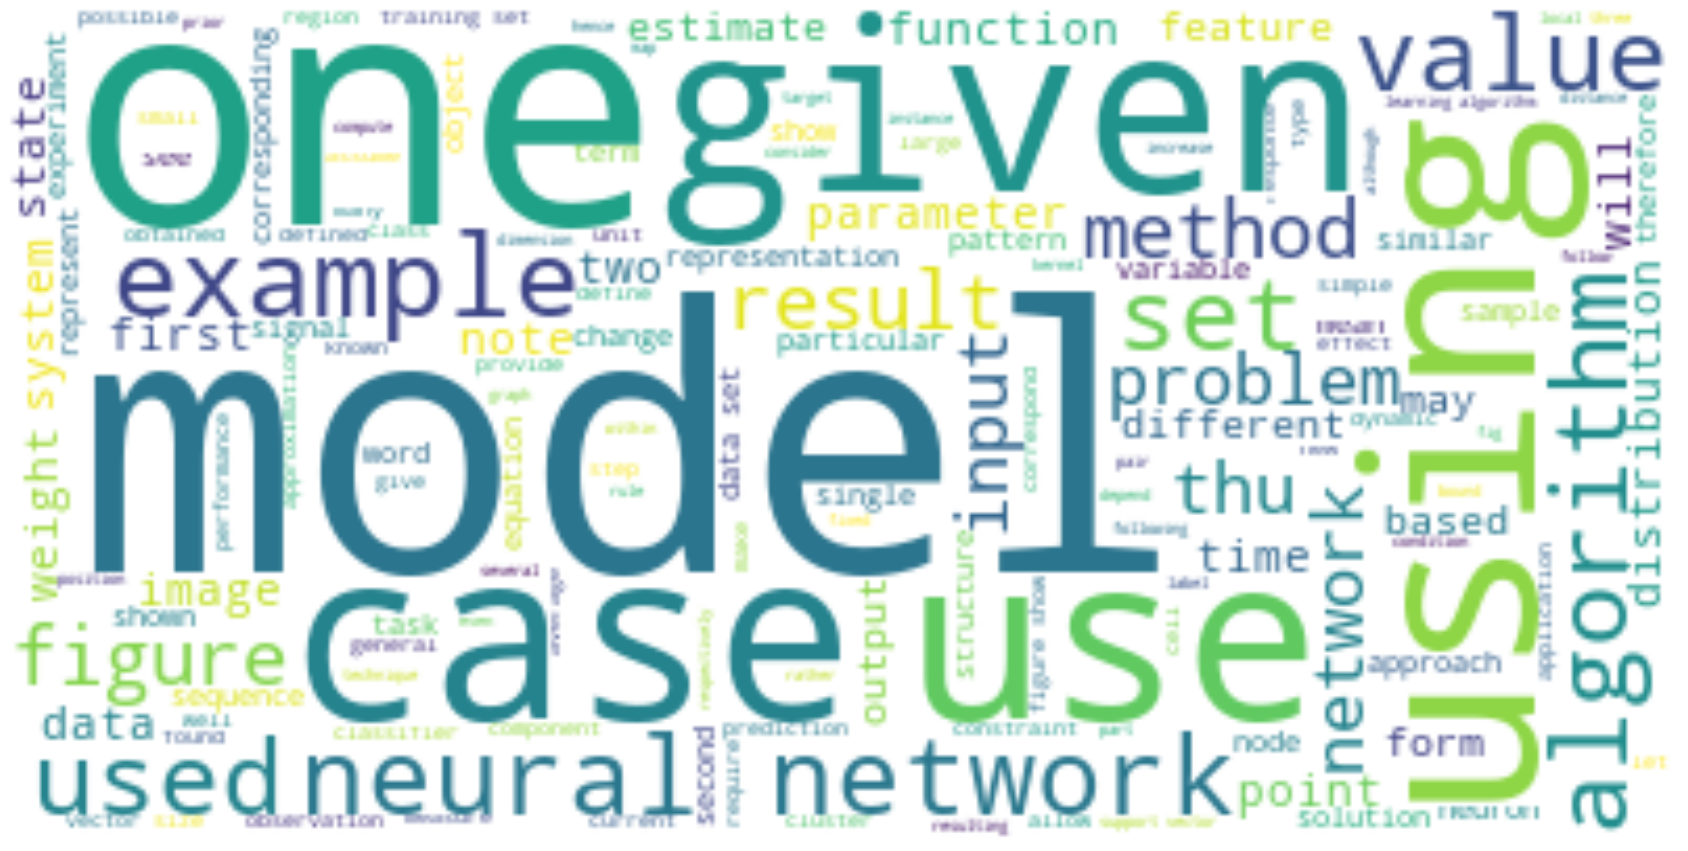

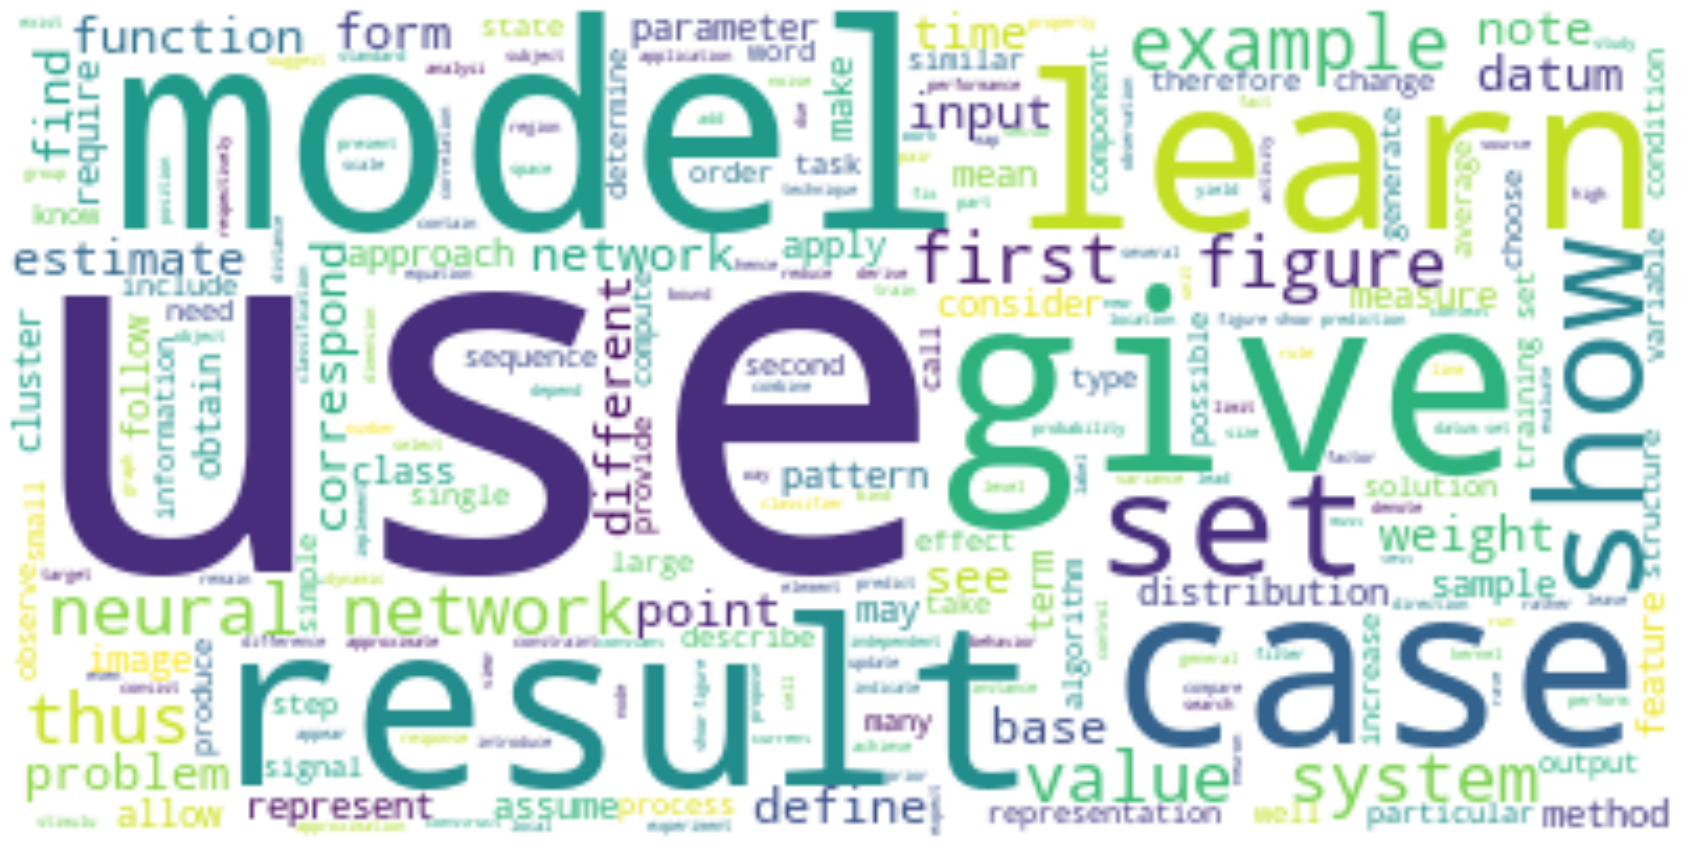

In [93]:
papers_all = pd.read_csv('drive/MyDrive/Colab Notebooks/papers.csv')
papers_all = papers_all[:2000]
papers_all = clean_data(papers_all)
data_all_lemmatized = prepare_data(papers_all['paper_text_processed'].values, 100)
ShowWordCloud(data_all_lemmatized)

In [94]:
papers = papers_all[:int(2*len(papers_all)/3)]
data_lemmatized = data_all_lemmatized[:int(2*len(papers_all)/3)]
papers_test = papers_all[int(2*len(papers_all)/3):]
data_test_lemmatized = data_all_lemmatized[int(2*len(papers_all)/3):]

In [95]:
id2word = corpora.Dictionary(data_all_lemmatized)

print(len(id2word))
id2word.filter_extremes(no_above=0.5, no_below=5)
print(len(id2word))

corpus_all = [id2word.doc2bow(text) for text in data_all_lemmatized]
corpus_train = corpus_all[:int(2*len(papers_all)/3)]
corpus_test = corpus_all[int(2*len(papers_all)/3):]

41767
9366


## LDA Gensim

In [109]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto')
pprint(lda_model.print_topics())

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(0,
  '0.022*"neuron" + 0.019*"cell" + 0.012*"response" + 0.010*"activity" + '
  '0.010*"stimulus" + 0.009*"unit" + 0.009*"signal" + 0.009*"spike" + '
  '0.006*"synaptic" + 0.006*"dynamic"'),
 (1,
  '0.011*"cluster" + 0.010*"mixture" + 0.009*"prior" + 0.009*"gaussian" + '
  '0.009*"component" + 0.008*"word" + 0.008*"density" + 0.008*"noise" + '
  '0.007*"sequence" + 0.006*"posterior"'),
 (2,
  '0.019*"action" + 0.017*"policy" + 0.014*"tree" + 0.008*"optimal" + '
  '0.008*"control" + 0.008*"node" + 0.008*"reward" + 0.007*"decision" + '
  '0.007*"agent" + 0.007*"search"'),
 (3,
  '0.017*"kernel" + 0.006*"classifier" + 0.006*"bound" + '
  '0.006*"classification" + 0.006*"theorem" + 0.006*"bind" + 0.006*"loss" + '
  '0.005*"label" + 0.005*"machine" + 0.005*"generalization"'),
 (4,
  '0.042*"image" + 0.019*"object" + 0.009*"visual" + 0.009*"face" + '
  '0.008*"representation" + 0.008*"location" + 0.008*"map" + 0.007*"region" + '
  '0.007*"motion" + 0.007*"circuit"')]


In [111]:
measure_model(lda_model)

-7.791110466642255
0.5023526719836419


In [112]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_all, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.127938 -0.002899       1        1  26.336697
1     -0.073117  0.074238       2        1  24.075416
2     -0.116816 -0.086788       3        1  17.770629
0      0.184530 -0.139503       4        1  17.028939
4      0.133341  0.154952       5        1  14.788320, topic_info=            Term          Freq         Total Category  logprob  loglift
213        image  10026.000000  10026.000000  Default  30.0000  30.0000
613       neuron   5900.000000   5900.000000  Default  29.0000  29.0000
2334      kernel   7364.000000   7364.000000  Default  28.0000  28.0000
703       action   5474.000000   5474.000000  Default  27.0000  27.0000
2856      policy   4677.000000   4677.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
543     distance   1061.087232   2837.970341   Topic5  -5.3873   0.9275
267        match    864.126272   1602.397738   Topic5  -5.5926   1.2938
41         basis   1051.215157   3537.414932   Topic5  -5.3966   0.6979
1669  coordinate    834.619517   1930.557020   Topic5  -5.6273   1.0727
592        layer    842.797515   3400.596404   Topic5  -5.6176   0.5164

[363 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
703       3  0.968843    action
703       4  0.031053    action
486       1  0.000368  activity
486       2  0.002579  activity
486       3  0.000737  activity
...     ...       ...       ...
481       1  0.013160      word
481       2  0.954365      word
481       3  0.013459      word
481       4  0.010169      word
481       5  0.008673      word

[879 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])

### Custom hyperparameter tuning

In [102]:
def hypertuning(corpus, texts, limit=13, start=3, step=2):
    model_results = {'num_topics': [],
                      'coherence': []
                      }

    for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=num_topics, 
                                              random_state=100,
                                              chunksize=100,
                                              passes=10,
                                              eta='auto',
                                              alpha='auto')
      coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
      coh = coherence_model.get_coherence()
      # perpl = model.log_perplexity(corpus_test)
      model_results['num_topics'].append(num_topics)
      model_results['coherence'].append(coh)
      print(coh)
    return model_results

In [103]:
model_results = hypertuning(corpus_train, data_all_lemmatized)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


0.43348057607187207
0.5023526719836419
0.5290894703081845
0.49991874619252147
0.49538809059368644


In [104]:
best_res = max(model_results['coherence'])
i = model_results['coherence'].index(best_res)
for x in model_results:
  print(x)
  print(model_results[x][i])

num_topics
7
coherence
0.5290894703081845


In [105]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                        id2word=id2word,
                                        num_topics=model_results['num_topics'][i], 
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        alpha='auto',
                                        eta='auto')

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [106]:
measure_model(model)

-7.748833615038605
0.5290894703081845


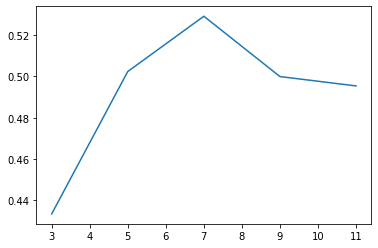

In [107]:
plt.plot(model_results['num_topics'], model_results['coherence'])
plt.show()

In [108]:
pyLDAvis.enable_notebook()
vis_best = pyLDAvis.gensim_models.prepare(model, corpus_all, id2word)
vis_best

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.133365 -0.013233       1        1  21.442658
6      0.074344  0.016691       2        1  20.257772
1      0.109185  0.048834       3        1  17.231384
4     -0.067443  0.216510       4        1  10.987270
5     -0.194777 -0.000600       5        1  10.627955
0     -0.179335 -0.141817       6        1  10.277833
2      0.124661 -0.126387       7        1   9.175128, topic_info=               Term          Freq         Total Category  logprob  loglift
213           image  10092.000000  10092.000000  Default  30.0000  30.0000
703          action   5233.000000   5233.000000  Default  29.0000  29.0000
512            cell   5970.000000   5970.000000  Default  28.0000  28.0000
2856         policy   4479.000000   4479.000000  Default  27.0000  27.0000
2334         kernel   7276.000000   7276.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
95         converge    563.671936   1878.575974   Topic7  -5.5425   1.1849
1482         update    598.819788   3090.486674   Topic7  -5.4820   0.7476
678      stochastic    526.289716   1342.695806   Topic7  -5.6111   1.4521
20    approximation    550.055394   3564.959064   Topic7  -5.5669   0.5198
299     observation    525.832006   2739.457698   Topic7  -5.6120   0.7381

[528 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1055      1  0.093828  accuracy
1055      2  0.640163  accuracy
1055      3  0.152388  accuracy
1055      4  0.072534  accuracy
1055      5  0.021294  accuracy
...     ...       ...       ...
481       3  0.016259      word
481       4  0.000800      word
481       5  0.010128      word
481       6  0.015459      word
481       7  0.000533      word

[1454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 2, 5, 6, 1, 3])

## LDA scipy

In [2]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            )
data_all_lemmatized_texts = [' '.join(doc) for doc in data_all_lemmatized]
data_lemmatized_texts = [' '.join(doc) for doc in data_lemmatized]
data_all_vectorized = vectorizer.fit_transform(data_all_lemmatized_texts)
data_train_vectorized = vectorizer.fit_transform(data_lemmatized_texts)

NameError: ignored

In [ ]:
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

In [ ]:
lda_scipy = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_scipy.fit_transform(data_all_vectorized)

print(lda_scipy)  # Model attributes

In [ ]:
lda_scipy.transform(data_vectorized[1])

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_components': [6, 8, 10, 12], # Maybe we can get away with fewer n_components (memory)
    'learning_decay': [0.75, 0.80, 0.85]
}

lda_search = GridSearchCV(lda_scipy,
                          n_jobs=-1,
                          param_grid=params)

lda_search.fit(data_train_vectorized)
best = lda_search.best_estimator_

results = pd.DataFrame(lda_search.cv_results_)

In [ ]:
print("Perplexity: ", lda_scipy.perplexity(data_vectorized))

## LDA mallet

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_train, num_topics=20, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

In [ ]:
import numpy as np
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [ ]:
pyLDAvis.enable_notebook()
converted_mallet = mallet_to_lda(ldamallet)
vis = pyLDAvis.gensim_models.prepare(converted_mallet, corpus_all, id2word)
vis

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_all_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
def compute_coherence_values(corpus, texts, limit=25, start=5, step=2):
    model_list = []
    model_results = {'num_topics': [],
                      'alpha': [],
                      'coherence': []
                      }
    alpha = list(np.arange(0.01, 1, 0.3))

    for num_topics in range(start, limit, step):
      for a in alpha:
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, alpha=a)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coh = coherence_model.get_coherence()
        model_results['num_topics'].append(num_topics)
        model_results['alpha'].append(a)
        model_results['coherence'].append(coh)
    return model_list, model_results

In [ ]:
model_list, model_results = compute_coherence_values(corpus_train, data_all_lemmatized)
model_results

In [ ]:
max_value = max(model_results['coherence'])
max_index = model_results['coherence'].index(max_value)
print(max_value)

a1 = {'num_topics': [], 'coherence': []} #alpha = 0.01
a2 = {'num_topics': [], 'coherence': []} #alpha = 0.31
a3 = {'num_topics': [], 'coherence': []} #alpha = 0.61
a4 = {'num_topics': [], 'coherence': []} #alpha = 0.91

for i in range (0,40):
  if model_results['alpha'][i] == 0.01:
    a1['num_topics'].append(model_results['num_topics'][i])
    a1['coherence'].append(model_results['coherence'][i])
  elif model_results['alpha'][i] == 0.31:
    a2['num_topics'].append(model_results['num_topics'][i])
    a2['coherence'].append(model_results['coherence'][i])
  elif model_results['alpha'][i] == 0.61:
    a3['num_topics'].append(model_results['num_topics'][i])
    a3['coherence'].append(model_results['coherence'][i])
  else:
    a4['num_topics'].append(model_results['num_topics'][i])
    a4['coherence'].append(model_results['coherence'][i])

plt.plot(a1['num_topics'], a1['coherence'])
plt.show()
plt.plot(a2['num_topics'], a2['coherence'])
plt.show()
plt.plot(a3['num_topics'], a3['coherence'])
plt.show()
plt.plot(a4['num_topics'], a4['coherence'])
plt.show()

print(model_results['coherence'][max_index])
print(model_results['num_topics'][max_index])
print(model_results['alpha'][max_index])